# SSD

In [15]:
!git clone https://github.com/sizhky/ssd-utils/
%cd ssd-utils

C:\Users\olive\OneDrive - University of Southampton\Research\Object Detection\RCNN\ssd-utils


Cloning into 'ssd-utils'...


In [141]:
import numpy as np
import torch 
import torchvision
from torchvision import transforms
from torch import nn
import torch_snippets
from torch_snippets import *
from torchvision.datasets import VOCDetection
from torchvision.transforms import ToTensor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from model import SSD300, MultiBoxLoss
from detect import *
from torch import optim
import selectivesearch
from IPython.display import clear_output
from torch_snippets import Report
from torchvision.ops import nms
from PIL import Image
import os
import pickle
import glob
import cv2
import pandas as pd
import xmltodict

# As the RoIPool layer not implemented on mps 
# Must use either cuda or cpu
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='cuda')

# Hyperparameters

In [30]:
# Optimation
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
MOMENTUM = 0.9

# Training params 
EPOCHS = 5
BATCH_SIZE = 4
N_CLASSES = 21

# Utility Functions

In [18]:
def get_bounding_boxes(y):
    objects = y['annotation']['object']
    bboxs = []
    for obj in objects:
        bbox = list(obj['bndbox'].values())
        bbox = [int(i) for i in bbox]
        bboxs.append(bbox)
    return torch.tensor(bboxs)


In [19]:
def get_class_labels(y, encode_labels=None):
    objects = y['annotation']['object']
    class_labels = []
    
    if encode_labels:
        for obj in objects:
            label_name = obj['name']
            label = encode_labels.index(label_name)
            class_labels.append(label)
        return torch.tensor(class_labels)
    else: 
        for obj in objects:
            label = obj['name']
            class_labels.append(str(label))
        return class_labels
    

In [33]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                 std=[0.229, 0.224, 0.225])

denormalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
                                   std=[1/0.229, 1/0.224, 1/0.225])

def preprocess_image(img):
    img = torch.tensor(img).permute(2, 0, 1)
    img = normalize(img)
    return img.to(device).float()

# Build the Dataset

In [118]:
class FRCNNDataset(Dataset):
    def __init__(self, root_dir='../VOC_data/', set_type='train'):
        self.root = root_dir
        self.ds = pd.read_csv(root_dir + "df_" + set_type + ".csv")
        self.set_type = set_type
        self.image_ids = self.ds["image_idx"].unique()
        self.resize = torchvision.transforms.Resize((300,300))
        
        if set_type=='train':
            self.raw_ds = VOCDetection(root='data/',year ='2012', 
                                       image_set="train", download=True, 
                                       transform=ToTensor())
        elif set_type=='test':
            self.raw_ds = VOCDetection(root='data/',year ='2012', 
                                       image_set="val", download=True, 
                                       transform=ToTensor())
        elif set_type=='val':
            self.raw_ds = VOCDetection(root='data/',year ='2012', 
                                       image_set="trainval", download=True, 
                                       transform=ToTensor())
        else:
            print("set_type must be train, test or trainval")
        
            
        self.labels = ["background", "person", "bird", "cat", "cow", "dog", "horse", "sheep", 
                       "aeroplane", "bicycle", "boat", "bus", "car", "motorbike", "train", 
                       "bottle", "chair", "diningtable", "pottedplant", "sofa", "tvmonitor"]
        
    def __len__(self):
        return len(self.image_ids)
        
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image, target = self.raw_ds.__getitem__(image_id)
        image = self.resize(image)
        image = image.permute(1, 2, 0).numpy()
        gtbbs = get_bounding_boxes(target)
        gtbbs = [list(box) for box in gtbbs.numpy()]
        labels = get_class_labels(target)
        return image, gtbbs, labels  
    
    def collate_fn(self, batch):
        images, boxes, labels = [], [], []
        for item in batch:
            image, image_boxes, image_labels = item
            image = preprocess_image(image)
            images.append(image)
            boxes.append(torch.tensor(image_boxes).float().to(device)/300.0)
            labels.append(torch.tensor([self.labels.index(l) for l in image_labels]).long().to(device))
        all_images = torch.cat(images).reshape(len(images), 3, 300, 300).to(device)
        all_boxes = torch.cat(boxes).reshape(len(boxes), len(batch)a, 4).to(device)
        
        return all_images, boxes, labels
            

In [119]:
train_ds = FRCNNDataset(set_type='train')
test_ds = FRCNNDataset(set_type='test')

Using downloaded and verified file: data/VOCtrainval_11-May-2012.tar
Extracting data/VOCtrainval_11-May-2012.tar to data/
Using downloaded and verified file: data/VOCtrainval_11-May-2012.tar
Extracting data/VOCtrainval_11-May-2012.tar to data/


In [120]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, collate_fn=train_ds.collate_fn, drop_last=True)

In [130]:
def train_batch(inputs, model, criterion, optimizer):
    model.train()
    N = len(train_loader)
    images, boxes, labels = inputs
    _regr, _clss = model(images)
    loss = criterion(_regr, _clss, boxes, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def validate_batch(inputs, model, criterion):
    model.eval()
    images, boxes, labels = inputs 
    _regr, _clss = model(images)
    loss = criterion(_regr, _clss, boxes, labels)
    return loss

# Load Model

In [131]:
model = SSD300(N_CLASSES, device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy, device=device)

log = Report(n_epochs=EPOCHS)
logs_to_print = 5

C:\Users\olive\miniconda3\envs\torch_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\olive\miniconda3\envs\torch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Loaded base model.



C:\Users\olive\miniconda3\envs\torch_env\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [134]:
for epoch in range(EPOCHS):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss = train_batch(inputs, model, criterion, optimizer)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), end="\r")
    
    _n = len(test_loader)
    for ix, inputs in enumerate(test_loader):
        loss = validate_batch(inputs, model, criterion)
        pos = (epoch + (ix + 1)/_n)
        log.record(pos, val_loss=loss.item(), end="\r")

EPOCH: 5.000  val_loss: 6.125  (690.29s - 0.00s remaining))))))

100%|███████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 872.21it/s]


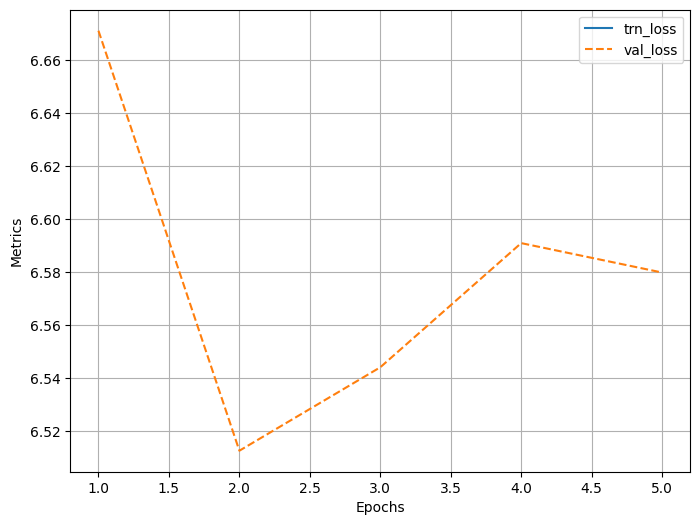

In [137]:
log.plot_epochs('trn_loss,val_loss'.split(','))

# Visualize

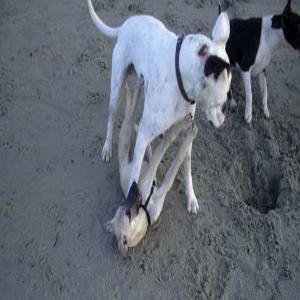

In [176]:
img, box, label = train_ds.__getitem__(2)

PIL_image = Image.fromarray(np.uint8(img*255)).convert('RGB')
PIL_image

In [177]:
bbs, labels, scores = detect(PIL_image, model, min_score=0.9, max_overlap=0.5, top_k=200, device=device)
print(labels, scores)

tensor[1] i64 cuda:0 [0]
[0.0]

[[0, 0, 300, 300]]
['background @ 0.00']

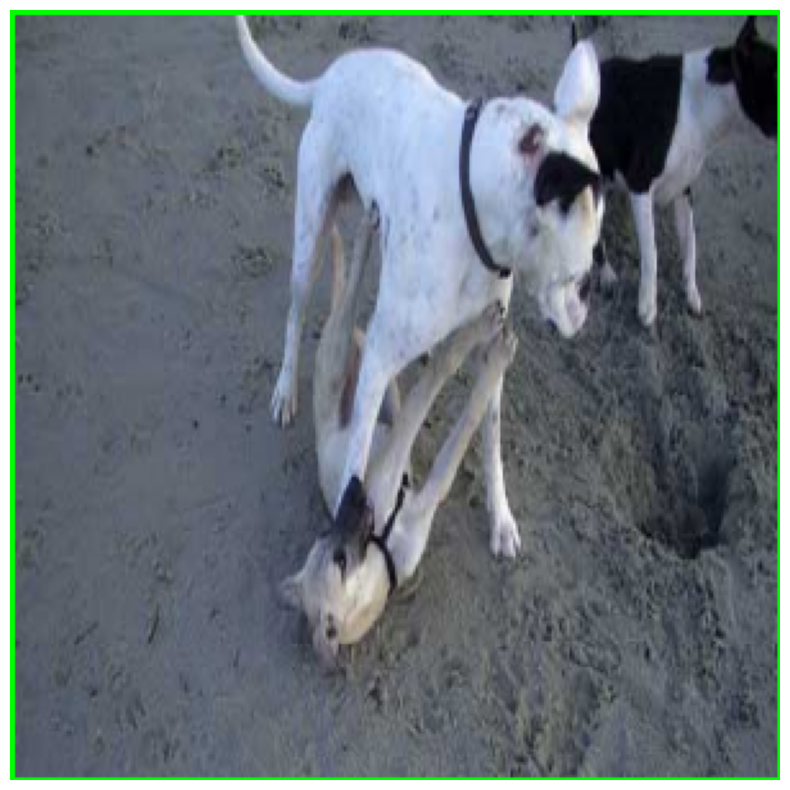

In [178]:
labels = [train_ds.labels[i] for i in labels]
label_with_conf = [f'{l} @ {s:.2f}' for l, s, in zip(labels, scores)]
print(bbs, label_with_conf)
show(PIL_image, bbs=bbs)# texts=label_with_conf, text_sz=10)